In [1]:
#############################
'''
lstm 모델을 사용한 종가 예측.
lookback을 설정하여 설정한 기간만큼의 데이터셋과 그 다음날의 종가 가격의 타겟을 구한다.
각 스칼라 값은 0~1로 정규화했다.
train, test set을 (samples, times stamps, features) #전체 looback 데이터 셋, 1일, looback수
'''

'\n\nㅇㄹㅇㄹㅇ\n'

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [143]:
connection= pymysql.connect(host='52.78.221.205', port=3306, user="quantec", passwd="!quant0330", database="QTDB", charset='utf8')

try:
    with connection.cursor() as cursor:
        sql = 'select distinct(SYMBOL) from PLAN_DB;'
        cursor.execute(sql)
        row =cursor.fetchall()
        print(len(row))
        for r in row:
            print(r)
finally:
    connection.close()

308
('AAP',)
('AAPL',)
('AAXN',)
('ABBV',)
('ABEV',)
('ABT',)
('ADBE',)
('AEM',)
('AGN',)
('AGR',)
('ALC',)
('ALGN',)
('ALLE',)
('ALV',)
('ALXN',)
('AMAT',)
('AMD',)
('AMGN',)
('AMT',)
('AMZN',)
('APO',)
('APTV',)
('ARCC',)
('ARE',)
('ATO',)
('ATUS',)
('ATVI',)
('AVB',)
('AWK',)
('AZN',)
('AZO',)
('BA',)
('BABA',)
('BAC',)
('BAM',)
('BHP',)
('BIDU',)
('BKNG',)
('BMY',)
('BP',)
('BSM',)
('BSX',)
('BTG',)
('BUD',)
('BWA',)
('BX',)
('BYND',)
('C',)
('CAT',)
('CERN',)
('CF',)
('CHE',)
('CHKP',)
('CHL',)
('CHTR',)
('CHU',)
('CL',)
('CMCSA',)
('CME',)
('CNI',)
('CNP',)
('COG',)
('COP',)
('COST',)
('CPRT',)
('CRM',)
('CSCO',)
('CSX',)
('CTXS',)
('CVS',)
('CVX',)
('D',)
('DAL',)
('DBX',)
('DD',)
('DEO',)
('DG',)
('DGX',)
('DHI',)
('DHR',)
('DIOD',)
('DIS',)
('DISCA',)
('DLR',)
('DNKN',)
('DOV',)
('DRI',)
('DTE',)
('DUK',)
('DVN',)
('DXCM',)
('EA',)
('EBAY',)
('EL',)
('ELY',)
('EMR',)
('ENB',)
('EPD',)
('EQIX',)
('EQM',)
('EQR',)
('EQT',)
('ERIC',)
('ES',)
('ESS',)
('EW',)
('EXAS',)
('EXC',)
('

In [2]:
import pymysql

connection= pymysql.connect(host='52.78.221.205', port=3306, user="quantec", passwd="!quant0330", database="QTDB", charset='utf8')
data = []
day = []
try:
    
    with connection.cursor() as cursor:
        sql="select OPEN_PRICE open, HIGH_PRICE high, LOW_PRICE low, LAST_PRICE last, VOLUME volume from PLAN_DB where SYMBOL='AAPL' order by ASOFDATE asc;"
        cursor.execute(sql)
        row=cursor.fetchall()
        print(len(row))
        for r in row:
#             day.append(r[0])
#             day.append(r[1])
#             day.append(r[2])
#             day.append(r[3])
#             day.append(r[4])
#             data.append(day)
            data.append(list(r))
finally:
    connection.close()

9894


In [3]:
data

[[28.750401, 28.8752, 28.750401, 28.750401, 2093900.0],
 [27.250401, 27.3752, 27.250401, 27.250401, 785200.0],
 [25.250401, 25.3752, 25.250401, 25.250401, 472000.0],
 [25.8752, 26.0, 25.8752, 25.8752, 385900.0],
 [26.625601, 26.750401, 26.625601, 26.625601, 327900.0],
 [28.250401, 28.3752, 28.250401, 28.250401, 217100.0],
 [29.625601, 29.750401, 29.625601, 29.625601, 166800.0],
 [30.8752, 31.0, 30.8752, 30.8752, 209600.0],
 [32.5, 32.625599, 32.5, 32.5, 214300.0],
 [35.5, 35.625599, 35.5, 35.5, 248100.0],
 [36.0, 36.125599, 36.0, 36.0, 415900.0],
 [35.125599, 35.250401, 35.125599, 35.125599, 307500.0],
 [34.125599, 34.250401, 34.125599, 34.125599, 159600.0],
 [24.250401, 24.3752, 24.250401, 24.250401, 152100.0],
 [28.3752, 28.625601, 28.3752, 28.3752, 73900.0],
 [33.125599, 33.250401, 33.125599, 33.125599, 228800.0],
 [25.750401, 25.8752, 25.750401, 25.750401, 761000.0],
 [21.3752, 21.5, 21.3752, 21.3752, 165300.0],
 [15.2504, 15.3752, 15.2504, 15.2504, 272900.0],
 [18.625601, 18.75040

In [4]:
df = pd.DataFrame(data=(np.array(data)), columns=['open', 'high', 'low', 'last', 'volume'])
df

,open,high,low,last,volume
0,28.750401,28.875200,28.750401,28.750401,2093900.0
1,27.250401,27.375200,27.250401,27.250401,785200.0
2,25.250401,25.375200,25.250401,25.250401,472000.0
3,25.875200,26.000000,25.875200,25.875200,385900.0
4,26.625601,26.750401,26.625601,26.625601,327900.0
...,...,...,...,...,...
9889,284.690000,284.890000,282.919700,284.270000,12119714.0
9890,284.820000,289.980000,284.700000,289.910000,23334004.0
9891,291.120000,293.970000,288.120000,289.800000,36592936.0
9892,289.460000,292.690000,285.220000,291.520000,36059614.0


In [5]:
df.isna().sum()

open      0
high      0
low       0
last      0
volume    0
dtype: int64

In [21]:
from pypfopt import expected_returns

returns = expected_returns.log_returns_from_prices(df)
returns

C:\Users\quantec\anaconda3\envs\tf_gpu1\lib\site-packages\pypfopt\expected_returns.py:52: RuntimeWarning: divide by zero encountered in log
  return np.log(1 + prices.pct_change()).dropna(how="all")


,open,high,low,last,volume
1,-0.053583,-0.053346,-0.053583,-0.053583,-0.980845
2,-0.076226,-0.075865,-0.076226,-0.076226,-0.508959
3,0.024443,0.024324,0.024443,0.024443,-0.201401
4,0.028588,0.028453,0.028588,0.028588,-0.162870
5,0.059234,0.058966,0.059234,0.059234,-0.412351
...,...,...,...,...,...
9889,0.014720,0.002249,0.009040,0.000950,-0.711074
9890,0.000457,0.017709,0.006273,0.019646,0.655078
9891,0.021878,0.013666,0.011941,-0.000380,0.449944
9892,-0.005718,-0.004364,-0.010116,0.005918,-0.014682


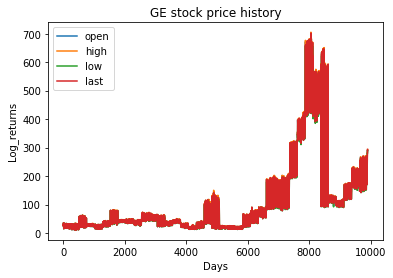

'\nplt.rcParams["figure.figsize"] = (20,5)\nfig, ax = plt.subplots()\n\nax.plot(returns[:])\n\nplt.show() # 전체 주가 그래프\n'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["open"])
plt.plot(df["high"])
plt.plot(df["low"])
plt.plot(df["last"])
plt.title('GE stock price history')
plt.ylabel('Log_returns')
plt.xlabel('Days')
plt.legend(['open','high','low','last'], loc='upper left')
plt.show()

'''
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots()

ax.plot(returns[:])

plt.show() # 전체 주가 그래프
'''

In [7]:
lookback = 200

In [257]:
def create_dataset(dataset, lookback): # lookback 기간에 맞추어 데이터셋 만들기
    dataX, dataY0, dataY1, dataY2, dataY3, dataY4, dataY= [], [], [], [], [], [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i : (i+lookback)]
        dataX.append(a) # X 데이터셋
        dataY0.append(dataset[i+lookback][0]) # Y0 데이터셋
        dataY1.append(dataset[i+lookback][1]) # Y1 데이터셋
        dataY2.append(dataset[i+lookback][2]) # Y2 데이터셋
        dataY3.append(dataset[i+lookback][3]) # Y3 데이터셋
        dataY4.append(dataset[i+lookback][3]) # Y4 데이터셋
        dataY.append(dataset[i+lookback])
    
    return np.array(dataX), np.array(dataY0), np.array(dataY1), np.array(dataY2), np.array(dataY3), np.array(dataY4), np.array(dataY)

In [12]:
nparr = np.array(df)
nparr.astype('float32')
nparr

array([[2.8750401e+01, 2.8875200e+01, 2.8750401e+01, 2.8750401e+01,
        2.0939000e+06],
       [2.7250401e+01, 2.7375200e+01, 2.7250401e+01, 2.7250401e+01,
        7.8520000e+05],
       [2.5250401e+01, 2.5375200e+01, 2.5250401e+01, 2.5250401e+01,
        4.7200000e+05],
       ...,
       [2.9112000e+02, 2.9397000e+02, 2.8812000e+02, 2.8980000e+02,
        3.6592936e+07],
       [2.8946000e+02, 2.9269000e+02, 2.8522000e+02, 2.9152000e+02,
        3.6059614e+07],
       [2.8993000e+02, 2.9368000e+02, 2.8952000e+02, 2.9365000e+02,
        2.5247625e+07]])

In [13]:
#nparr = nparr.reshape(-1,1)
#nparr
nparr = pd.DataFrame(nparr, columns=['open', 'high', 'low', 'last', 'volume'])
nparr

,open,high,low,last,volume
0,28.750401,28.875200,28.750401,28.750401,2093900.0
1,27.250401,27.375200,27.250401,27.250401,785200.0
2,25.250401,25.375200,25.250401,25.250401,472000.0
3,25.875200,26.000000,25.875200,25.875200,385900.0
4,26.625601,26.750401,26.625601,26.625601,327900.0
...,...,...,...,...,...
9889,284.690000,284.890000,282.919700,284.270000,12119714.0
9890,284.820000,289.980000,284.700000,289.910000,23334004.0
9891,291.120000,293.970000,288.120000,289.800000,36592936.0
9892,289.460000,292.690000,285.220000,291.520000,36059614.0


In [14]:
nparr

,open,high,low,last,volume
0,28.750401,28.875200,28.750401,28.750401,2093900.0
1,27.250401,27.375200,27.250401,27.250401,785200.0
2,25.250401,25.375200,25.250401,25.250401,472000.0
3,25.875200,26.000000,25.875200,25.875200,385900.0
4,26.625601,26.750401,26.625601,26.625601,327900.0
...,...,...,...,...,...
9889,284.690000,284.890000,282.919700,284.270000,12119714.0
9890,284.820000,289.980000,284.700000,289.910000,23334004.0
9891,291.120000,293.970000,288.120000,289.800000,36592936.0
9892,289.460000,292.690000,285.220000,291.520000,36059614.0


In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
nptf = scaler.fit_transform(nparr)

In [16]:
len(nptf)*(0.9)

8904.6

In [17]:
nptf.shape

(9894, 5)

In [227]:
testdate = 30 # 교차 검증할 테스트 데이터 일 수

In [228]:
train_data = nptf[:len(nptf)-testdate] # 학습시킬 데이터

test_data = nptf[len(nptf)-lookback - testdate:len(nptf)-testdate] # 진짜 검증할 때의 입력 dataset
val_data = nptf[len(nptf)-testdate:] # 진짜 검증할 때의 출력 dataset : 정답

cross_data = nptf[len(nptf)-lookback-testdate:]

In [229]:
sizes = int(len(train_data)*(0.9)) #trainset
print(sizes)
size = len(train_data)-sizes
print(size)
train = nptf[0:sizes] 
test = nptf[sizes:len(train_data)]

8877
987


In [230]:
test

array([[0.1386023 , 0.14104144, 0.13905901, 0.14127065, 0.16292785],
       [0.14094526, 0.13998873, 0.13952383, 0.13921558, 0.13281156],
       [0.13867462, 0.13758046, 0.13609581, 0.13623428, 0.21550236],
       ...,
       [0.36157356, 0.36506805, 0.36305676, 0.36664803, 0.13599211],
       [0.36536279, 0.36521226, 0.36455289, 0.36399959, 0.1179668 ],
       [0.36526155, 0.36651013, 0.36587471, 0.36851496, 0.13217888]])

In [258]:
trainX, trainY0, trainY1, trainY2, trainY3, trainY4, trainY = create_dataset(train, lookback)
testX, testY0, testY1, testY2, testY3, testY4, testY = create_dataset(test, lookback)

In [232]:
testY1

array([0.15364519, 0.15316931, 0.15370288, 0.15305394, 0.15250595,
       0.15182818, 0.1530251 , 0.15391919, 0.15008326, 0.150314  ,
       0.14937665, 0.14796341, 0.12608711, 0.11982849, 0.13073059,
       0.14274309, 0.11817011, 0.12405378, 0.1403204 , 0.15439507,
       0.14023388, 0.13870384, 0.13851781, 0.1421951 , 0.14236815,
       0.14264215, 0.14473316, 0.14535325, 0.14404096, 0.14456011,
       0.14541815, 0.14479084, 0.145036  , 0.12843769, 0.11951124,
       0.14258446, 0.11703087, 0.12412588, 0.13961379, 0.13569134,
       0.1533712 , 0.14907381, 0.15040052, 0.1508043 , 0.1515686 ,
       0.15123692, 0.15250595, 0.152679  , 0.15253479, 0.15125135,
       0.15126577, 0.15311162, 0.15342398, 0.15211587, 0.15224638,
       0.15224638, 0.17141158, 0.18534204, 0.19550868, 0.20434861,
       0.19986375, 0.22109112, 0.2283015 , 0.23079629, 0.1557362 ,
       0.15663029, 0.15700523, 0.15641398, 0.15693313, 0.15745228,
       0.1564284 , 0.15931255, 0.15980286, 0.15967307, 0.15863

In [47]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2])) #samples, times steps, features
testX = np.reshape(testX, (testX.shape[0], tes, testX.shape[2]))

ValueError: cannot reshape array of size 8595000 into shape (8595,1,200)

In [233]:
trainX

array([[[2.54901998e-02, 2.48752456e-02, 2.56009065e-02, 2.55071693e-02,
         1.10294512e-02],
        [2.33207966e-02, 2.27121306e-02, 2.34220814e-02, 2.33363219e-02,
         4.13597835e-03],
        [2.04282590e-02, 1.98279773e-02, 2.05169812e-02, 2.04418586e-02,
         2.48622234e-03],
        ...,
        [7.77282704e-03, 7.39035592e-03, 7.80658528e-03, 7.77800162e-03,
         6.63168204e-04],
        [7.59233269e-03, 7.02925848e-03, 7.62530703e-03, 7.59738711e-03,
         4.30348231e-04],
        [4.51930075e-03, 4.14510516e-03, 4.53892857e-03, 4.52230936e-03,
         8.13816422e-04]],

       [[2.33207966e-02, 2.27121306e-02, 2.34220814e-02, 2.33363219e-02,
         4.13597835e-03],
        [2.04282590e-02, 1.98279773e-02, 2.05169812e-02, 2.04418586e-02,
         2.48622234e-03],
        [2.13318863e-02, 2.07289868e-02, 2.14245330e-02, 2.13460875e-02,
         2.03269746e-03],
        ...,
        [7.59233269e-03, 7.02925848e-03, 7.62530703e-03, 7.59738711e-03,
        

In [31]:
from tensorflow.python.keras.layers.core import Activation, Dropout, Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import GlobalMaxPooling1D,Conv1D,LSTM

In [341]:
modelc= Sequential()
modelc.add(Conv1D(128, 5, input_shape=(1, 1, lookback, ), activation='relu'))
modelc.add(GlobalMaxPooling1D())
modelc.add(Dropout(0.2))
modelc.add(Dense(1, activation='sigmoid'))
modelc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
modelc.summary()

ValueError: Negative dimension size caused by subtracting 5 from 1 for 'conv1d_1/conv1d' (op: 'Conv2D') with input shapes: [?,1,1,200], [1,5,200,128].

In [266]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features
model.add(LSTM(512))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

#history = model.fit(trainX, trainY3, epochs=100, batch_size=128, verbose=1, validation_data=(testX, testY3))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 200, 512)          1060864   
_________________________________________________________________
lstm_28 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 3,160,577
Trainable params: 3,160,577
Non-trainable params: 0
_________________________________________________________________


In [271]:
modell = Sequential()
modell.add(LSTM(512, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features
modell.add(LSTM(512))
modell.add(Dense(5))
modell.compile(loss='mean_squared_error', optimizer='adam')
modell.summary()

#history = model.fit(trainX, trainY3, epochs=100, batch_size=128, verbose=1, validation_data=(testX, testY3))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 200, 512)          1060864   
_________________________________________________________________
lstm_32 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 2565      
Total params: 3,162,629
Trainable params: 3,162,629
Non-trainable params: 0
_________________________________________________________________


In [272]:
historyy = modell.fit(trainX, trainY, epochs=100, batch_size=128, verbose=1, validation_data=(testX, testY)) # 5개 속성 다 예측하는 학습

Train on 8676 samples, validate on 786 samples
Epoch 1/100
8676/8676 [==============================] - 79s 9ms/sample - loss: 0.0060 - val_loss: 0.0016
Epoch 2/100
8676/8676 [==============================] - 83s 10ms/sample - loss: 0.0027 - val_loss: 0.0016
Epoch 3/100
8676/8676 [==============================] - 78s 9ms/sample - loss: 0.0024 - val_loss: 0.0014
Epoch 4/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0022 - val_loss: 0.0014
Epoch 5/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 6/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0019 - val_loss: 0.0013
Epoch 7/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0017 - val_loss: 0.0012
Epoch 8/100
8676/8676 [==============================] - 72s 8ms/sample - loss: 0.0017 - val_loss: 0.0013
Epoch 9/100
8676/8676 [==============================] - 76s 9ms/sample - loss: 0.0018 - val_loss: 0.001

8676/8676 [==============================] - 78s 9ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 78/100
8676/8676 [==============================] - 86s 10ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 79/100
8676/8676 [==============================] - 81s 9ms/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 80/100
8676/8676 [==============================] - 80s 9ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 81/100
8676/8676 [==============================] - 81s 9ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 82/100
8676/8676 [==============================] - 79s 9ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 83/100
8676/8676 [==============================] - 79s 9ms/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 84/100
8676/8676 [==============================] - 86s 10ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 85/100
8676/8676 [==============================] - 84s 10ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 86/100
8676/8676 [=======================

In [267]:
history = model.fit(trainX, trainY3, epochs=100, batch_size=128, verbose=1, validation_data=(testX, testY3)) # 종가만 예측하는 학습

Train on 8676 samples, validate on 786 samples
Epoch 1/100
8676/8676 [==============================] - 89s 10ms/sample - loss: 0.0040 - val_loss: 6.0789e-04
Epoch 2/100
8676/8676 [==============================] - 72s 8ms/sample - loss: 0.0022 - val_loss: 5.6850e-04
Epoch 3/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0020 - val_loss: 5.9862e-04
Epoch 4/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0017 - val_loss: 0.0012
Epoch 5/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0018 - val_loss: 5.1230e-04
Epoch 6/100
8676/8676 [==============================] - 76s 9ms/sample - loss: 0.0017 - val_loss: 7.5433e-04
Epoch 7/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0017 - val_loss: 9.7047e-04
Epoch 8/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0018 - val_loss: 0.0010
Epoch 9/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 

8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0012 - val_loss: 5.2806e-04
Epoch 75/100
8676/8676 [==============================] - 72s 8ms/sample - loss: 0.0013 - val_loss: 5.1389e-04
Epoch 76/100
8676/8676 [==============================] - 72s 8ms/sample - loss: 0.0012 - val_loss: 5.4999e-04
Epoch 77/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0012 - val_loss: 7.8510e-04
Epoch 78/100
8676/8676 [==============================] - 75s 9ms/sample - loss: 0.0012 - val_loss: 5.3917e-04
Epoch 79/100
8676/8676 [==============================] - 72s 8ms/sample - loss: 0.0011 - val_loss: 5.2484e-04
Epoch 80/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0011 - val_loss: 5.1583e-04
Epoch 81/100
8676/8676 [==============================] - 72s 8ms/sample - loss: 0.0012 - val_loss: 4.9500e-04
Epoch 82/100
8676/8676 [==============================] - 73s 8ms/sample - loss: 0.0012 - val_loss: 4.8963e-04
Epoch 83/100
8

In [236]:
model0 = Sequential()
model0.add(LSTM(20, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features 
model0.add(Dense(1))
model0.compile(loss='mean_squared_error', optimizer='adam')
model0.summary()

model1 = Sequential()
model1.add(LSTM(20, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features 
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

model2 = Sequential()
model2.add(LSTM(20, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features 
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

model3 = Sequential() #333333333333333
model3.add(LSTM(20, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features 
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()

model4 = Sequential()
model4.add(LSTM(20, input_shape=(trainX.shape[1], trainX.shape[2]))) #timesteps, features 
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')
model4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 20)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
___

In [237]:
history0 = model0.fit(trainX, trainY0, epochs=40, batch_size=128, verbose=1, validation_data=(testX, testY0))
history1 = model1.fit(trainX, trainY1, epochs=40, batch_size=128, verbose=1, validation_data=(testX, testY1))
history2 = model2.fit(trainX, trainY2, epochs=40, batch_size=128, verbose=1, validation_data=(testX, testY2))
history3 = model3.fit(trainX, trainY3, epochs=40, batch_size=128, verbose=1, validation_data=(testX, testY3))
history4 = model4.fit(trainX, trainY4, epochs=40, batch_size=128, verbose=1, validation_data=(testX, testY4)) 

Train on 8676 samples, validate on 786 samples
Epoch 1/40
8676/8676 [==============================] - 41s 5ms/sample - loss: 0.0129 - val_loss: 9.5119e-04
Epoch 2/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0032 - val_loss: 8.1794e-04
Epoch 3/40
8676/8676 [==============================] - 35s 4ms/sample - loss: 0.0029 - val_loss: 7.4148e-04
Epoch 4/40
8676/8676 [==============================] - 35s 4ms/sample - loss: 0.0028 - val_loss: 6.8765e-04
Epoch 5/40
8676/8676 [==============================] - 35s 4ms/sample - loss: 0.0025 - val_loss: 6.5595e-04
Epoch 6/40
8676/8676 [==============================] - 37s 4ms/sample - loss: 0.0024 - val_loss: 6.3388e-04
Epoch 7/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0022 - val_loss: 5.8789e-04
Epoch 8/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0021 - val_loss: 5.7788e-04
Epoch 9/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.

Epoch 35/40
8676/8676 [==============================] - 32s 4ms/sample - loss: 0.0016 - val_loss: 5.3370e-04
Epoch 36/40
8676/8676 [==============================] - 32s 4ms/sample - loss: 0.0016 - val_loss: 5.0043e-04
Epoch 37/40
8676/8676 [==============================] - 32s 4ms/sample - loss: 0.0016 - val_loss: 4.7034e-04
Epoch 38/40
8676/8676 [==============================] - 32s 4ms/sample - loss: 0.0015 - val_loss: 4.9913e-04
Epoch 39/40
8676/8676 [==============================] - 32s 4ms/sample - loss: 0.0015 - val_loss: 4.7039e-04
Epoch 40/40
8676/8676 [==============================] - 32s 4ms/sample - loss: 0.0015 - val_loss: 4.9940e-04
Train on 8676 samples, validate on 786 samples
Epoch 1/40
8676/8676 [==============================] - 36s 4ms/sample - loss: 0.0078 - val_loss: 7.4527e-04
Epoch 2/40
8676/8676 [==============================] - 33s 4ms/sample - loss: 0.0026 - val_loss: 7.6316e-04
Epoch 3/40
8676/8676 [==============================] - 33s 4ms/sample - lo

Epoch 29/40
8676/8676 [==============================] - 33s 4ms/sample - loss: 0.0016 - val_loss: 4.9034e-04
Epoch 30/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 4.6774e-04
Epoch 31/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 4.7486e-04
Epoch 32/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 9.0151e-04
Epoch 33/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 6.1370e-04
Epoch 34/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 5.2085e-04
Epoch 35/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 6.2620e-04
Epoch 36/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0016 - val_loss: 7.2149e-04
Epoch 37/40
8676/8676 [==============================] - 34s 4ms/sample - loss: 0.0015 - val_loss: 4.7315e-04
Epoch 38/4

In [235]:
#del model0, model1, model2, model3, model4

In [316]:
model.save('lstm2layer_5-1.h5')
modell.save('lstm3layer_5-5.h5')

In [238]:
model0.save('open_price_model.h5')
model1.save('high_price_model.h5')
model2.save('low_price_model.h5')
model3.save('last_price_model.h5')
model4.save('volume_model.h5')

No handles with labels found to put in legend.


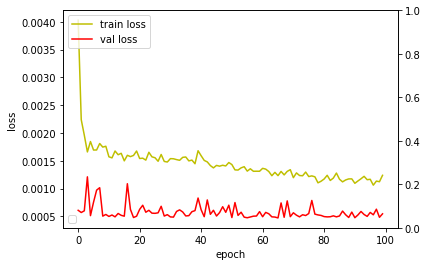

In [268]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')


#acc_ax.plot(history.history['acc'], 'b', label='train acc')
#acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

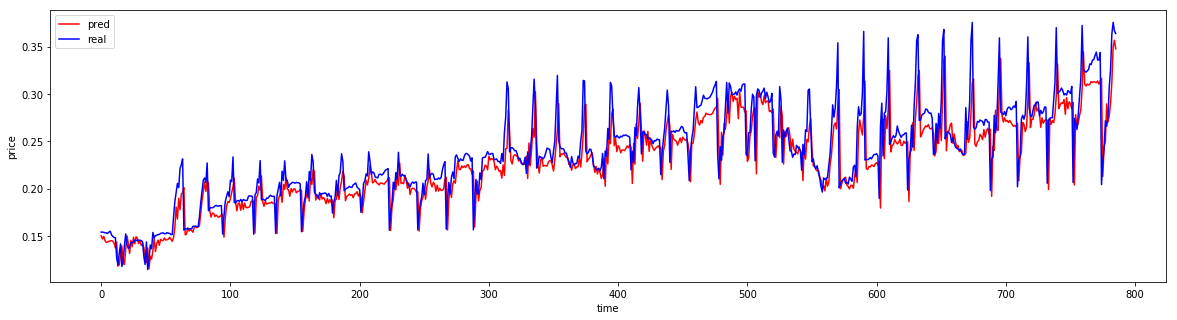

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

fig, aax = plt.subplots()

aax.plot(model.predict(testX), 'r', label='pred')
aax.plot(testY3, 'b', label='real')


aax.set_xlabel('time')
aax.set_ylabel('price')

aax.legend(loc='upper left')

plt.show()

In [67]:
model.predict(testX)
new_testXY = scaler.inverse_transform(model.predict(testX)) #minmaxscaler 한 것을! 다시 원상복구!
print(new_testXY)

[[9.87583389e+01 1.02377525e+02 9.73738022e+01 1.01958344e+02
  3.43983680e+07]
 [9.84174042e+01 1.01859200e+02 9.70350113e+01 1.01848763e+02
  3.39147520e+07]
 [9.54753342e+01 9.78160324e+01 9.94584808e+01 9.78731232e+01
  3.91581160e+07]
 ...
 [1.82755905e+02 1.91985413e+02 1.89098679e+02 1.91024124e+02
  3.11556480e+07]
 [1.84671967e+02 1.93631241e+02 1.91411652e+02 1.94519791e+02
  3.14594200e+07]
 [1.91862167e+02 2.00386261e+02 2.00155029e+02 2.07634399e+02
  3.09936660e+07]]


In [457]:
new_testY = scaler.inverse_transform(testY) #minmaxscaler 한 것을! 다시 원상복구!
new_testY

array([[ 7.84317746e-03],
       [ 1.54373869e-01],
       [-2.96703907e-02],
       [-6.87465964e-02],
       [ 9.06980111e-03],
       [-4.64718948e-03],
       [-4.91522248e-03],
       [ 1.41881049e-02],
       [-2.85804129e-02],
       [ 1.80809879e-02],
       [-5.90843669e-03],
       [-2.22469502e-03],
       [-5.45907063e-03],
       [-5.73925468e-03],
       [ 8.22434542e-03],
       [-1.87904815e-02],
       [-7.61618305e-03],
       [ 3.72682870e-02],
       [-1.14045859e-01],
       [ 1.05167872e-01],
       [ 5.09464421e-02],
       [-1.11184094e-01],
       [ 1.02673404e-01],
       [ 6.72502968e-02],
       [-9.03060731e-02],
       [-2.50935676e-02],
       [-2.36965966e-02],
       [ 1.54413902e-02],
       [ 3.51053520e-03],
       [ 1.09535574e-02],
       [-1.37107969e-02],
       [-2.01005093e-03],
       [-4.26470997e-02],
       [ 2.28344119e-02],
       [ 4.60712358e-03],
       [-1.07831597e-02],
       [-2.58164452e-04],
       [-1.71879231e-02],
       [ 8.5

In [210]:
xx = []
#ex_data = np.array(ex_data) 실험!!!
ex_data.shape
xx.append(ex_data)
print(xx)
xx = np.array(xx)
xx

[array([[0.30901616, 0.30891359, 0.30923978, 0.31059675, 0.1207786 ],
       [0.30901616, 0.30891359, 0.30923978, 0.31059675, 0.1207786 ],
       [0.2343453 , 0.23458896, 0.23513068, 0.23613668, 0.12620684],
       [0.23411389, 0.23415633, 0.23299543, 0.23463156, 0.15072323],
       [0.2554319 , 0.25776313, 0.25641054, 0.25893058, 0.14743135],
       [0.25972731, 0.25907542, 0.26008563, 0.25937922, 0.0839582 ],
       [0.28380769, 0.28477322, 0.28403804, 0.28424266, 0.12963754],
       [0.30346248, 0.3031597 , 0.29827303, 0.29987276, 0.20814976],
       [0.30998516, 0.30964905, 0.29766296, 0.29702171, 0.22118189],
       [0.22254374, 0.22851781, 0.22108452, 0.22934916, 0.32671697],
       [0.3037662 , 0.30313086, 0.29943507, 0.29846894, 0.16218917],
       [0.30054102, 0.30480367, 0.29869819, 0.30540118, 0.1537242 ],
       [0.30541495, 0.30429894, 0.30244185, 0.30401184, 0.120547  ],
       [0.29899351, 0.30011692, 0.29323268, 0.29652965, 0.17161948],
       [0.29928277, 0.30230888, 0

array([[[0.30901616, 0.30891359, 0.30923978, 0.31059675, 0.1207786 ],
        [0.30901616, 0.30891359, 0.30923978, 0.31059675, 0.1207786 ],
        [0.2343453 , 0.23458896, 0.23513068, 0.23613668, 0.12620684],
        [0.23411389, 0.23415633, 0.23299543, 0.23463156, 0.15072323],
        [0.2554319 , 0.25776313, 0.25641054, 0.25893058, 0.14743135],
        [0.25972731, 0.25907542, 0.26008563, 0.25937922, 0.0839582 ],
        [0.28380769, 0.28477322, 0.28403804, 0.28424266, 0.12963754],
        [0.30346248, 0.3031597 , 0.29827303, 0.29987276, 0.20814976],
        [0.30998516, 0.30964905, 0.29766296, 0.29702171, 0.22118189],
        [0.22254374, 0.22851781, 0.22108452, 0.22934916, 0.32671697],
        [0.3037662 , 0.30313086, 0.29943507, 0.29846894, 0.16218917],
        [0.30054102, 0.30480367, 0.29869819, 0.30540118, 0.1537242 ],
        [0.30541495, 0.30429894, 0.30244185, 0.30401184, 0.120547  ],
        [0.29899351, 0.30011692, 0.29323268, 0.29652965, 0.17161948],
        [0.29928277,

In [318]:
#상기
test_data #= nptf[len(nptf)-127:len(nptf)-7] #모델에 넣을 데이터
val_data #= nptf[len(nptf)-7:] #예측값과 비교할 실제 데이터
print(len(test_data))
print(len(val_data))
print((val_data[:, 3:4]))
print(testdate)

200
30
[[0.37045425]
 [0.36928199]
 [0.36479557]
 [0.36308784]
 [0.36275497]
 [0.36939777]
 [0.36638752]
 [0.3715252 ]
 [0.37067133]
 [0.23121609]
 [0.24571735]
 [0.27170963]
 [0.26493659]
 [0.27812087]
 [0.27403967]
 [0.30675435]
 [0.36301547]
 [0.37676418]
 [0.38210446]
 [0.38892092]
 [0.3897169 ]
 [0.38874725]
 [0.38915248]
 [0.38831308]
 [0.39491246]
 [0.39530321]
 [0.4034656 ]
 [0.4033064 ]
 [0.40579564]
 [0.40887824]]
30


In [335]:
#초기화
ex_data = test_data #모델에 넣을 데이터
#vv_data = val_data[:, 3:4]
predict_data = [] #np.array([])

In [331]:
dataX, dataY0, dataY1, dataY2, dataY3, dataY4, dataY = create_dataset(cross_data, lookback)
dataX

array([[[0.27520239, 0.27616734, 0.276325  , 0.27729595, 0.0892049 ],
        [0.28116102, 0.28092288, 0.27671719, 0.27916287, 0.21523797],
        [0.30651411, 0.30565449, 0.30039375, 0.30078452, 0.18840117],
        ...,
        [0.36157356, 0.36506805, 0.36305676, 0.36664803, 0.13599211],
        [0.36536279, 0.36521226, 0.36455289, 0.36399959, 0.1179668 ],
        [0.36526155, 0.36651013, 0.36587471, 0.36851496, 0.13217888]],

       [[0.28116102, 0.28092288, 0.27671719, 0.27916287, 0.21523797],
        [0.30651411, 0.30565449, 0.30039375, 0.30078452, 0.18840117],
        [0.37045365, 0.37007206, 0.36651383, 0.36619938, 0.12480388],
        ...,
        [0.36536279, 0.36521226, 0.36455289, 0.36399959, 0.1179668 ],
        [0.36526155, 0.36651013, 0.36587471, 0.36851496, 0.13217888],
        [0.36832764, 0.36888956, 0.36764682, 0.37045425, 0.11430774]],

       [[0.30651411, 0.30565449, 0.30039375, 0.30078452, 0.18840117],
        [0.37045365, 0.37007206, 0.36651383, 0.36619938, 0.1

In [326]:
def ccreate_val_dataset(ex_data): # 예측된 가격을 lookback에 넣어서 그 다음 가격을 예측 하는 데이터셋 만드는 메소드
    global predict_data
    t_data = ex_data[1:] # 뒤에 하루가 추가될 것이므로 맨 앞의 하루는 제거
    tt_data = []
    tt_data.append(ex_data)
    tt_data = np.array(tt_data)
    valuee = model.predict(tt_data) # lookback 기간 다음날 예측
    print(valuee)
   
    t_data = np.concatenate((t_data, valuee), axis=0) # 모델에 넣을 입력 데이터에 예측한 마지막 하루의 데이터 입력
    predict_data.append(valuee.tolist()[0]) # 예측한 데이터만 모아둔 데이터셋
    #predict_data = np.append(predict_data.tolist(), value.tolist()) # 예측한 데이터만 모아둔 데이터셋
    
    return t_data

In [336]:
def create_val_dataset(ex_data): # 예측된 가격을 lookback에 넣어서 그 다음 가격을 예측 하는 데이터셋 만드는 메소드
    global predict_data
    #print(ex_data[:10])
    #print("ddd")
    t_data = ex_data[1:] # 뒤에 하루가 추가될 것이므로 맨 앞의 하루는 제거
    #print(ex_data[:1])
    #print("?????")
    tt_data = []
    tt_data.append(ex_data)
    tt_data = np.array(tt_data)
    #ex_data = np.reshape(ex_data, (1, lookback, 5)) # 입력할 데이터 구조 바꾸기
    value0 = model.predict(tt_data) # lookback 기간 다음날 예측
    value1 = model.predict(tt_data) # lookback 기간 다음날 예측
    value2 = model.predict(tt_data) # lookback 기간 다음날 예측
    value3 = model.predict(tt_data) # lookback 기간 다음날 예측
    value4 = model.predict(tt_data) # lookback 기간 다음날 예측
    value = []
    value.append(value0.tolist()[0][0])
    value.append(value1.tolist()[0][0])
    value.append(value2.tolist()[0][0])    
    value.append(value3.tolist()[0][0])    
    value.append(value4.tolist()[0][0])
    vv = []
    vv.append(value)
    print(vv)
   
    t_data = np.concatenate((t_data, vv), axis=0) # 모델에 넣을 입력 데이터에 예측한 마지막 하루의 데이터 입력
    predict_data.append(value) # 예측한 데이터만 모아둔 데이터셋
    #predict_data = np.append(predict_data.tolist(), value.tolist()) # 예측한 데이터만 모아둔 데이터셋
    
    return t_data

In [337]:
for i in range(testdate):
    ex_data = create_val_dataset(ex_data)
    #print(predict_data)

[[0.35027214884757996, 0.35027214884757996, 0.35027214884757996, 0.35027214884757996, 0.35027214884757996]]
[[0.3247361481189728, 0.3247361481189728, 0.3247361481189728, 0.3247361481189728, 0.3247361481189728]]
[[0.31907710433006287, 0.31907710433006287, 0.31907710433006287, 0.31907710433006287, 0.31907710433006287]]
[[0.3119291365146637, 0.3119291365146637, 0.3119291365146637, 0.3119291365146637, 0.3119291365146637]]
[[0.30623748898506165, 0.30623748898506165, 0.30623748898506165, 0.30623748898506165, 0.30623748898506165]]
[[0.3015716075897217, 0.3015716075897217, 0.3015716075897217, 0.3015716075897217, 0.3015716075897217]]
[[0.2925852835178375, 0.2925852835178375, 0.2925852835178375, 0.2925852835178375, 0.2925852835178375]]
[[0.28337880969047546, 0.28337880969047546, 0.28337880969047546, 0.28337880969047546, 0.28337880969047546]]
[[0.27459296584129333, 0.27459296584129333, 0.27459296584129333, 0.27459296584129333, 0.27459296584129333]]
[[0.2677602469921112, 0.2677602469921112, 0.2677

In [330]:
#predict_data = model3.predict(xx)
print(predict_data)
print(val_data)

[]
[[0.36832764 0.36888956 0.36764682 0.37045425 0.11430774]
 [0.3713648  0.36971154 0.36933556 0.36928199 0.10044758]
 [0.36795161 0.36694708 0.36208356 0.36479557 0.14016563]
 [0.36527601 0.36395044 0.36321654 0.36308784 0.15985977]
 [0.36368512 0.36276073 0.36272268 0.36275497 0.08602362]
 [0.36385867 0.3674619  0.36516296 0.36939777 0.1107713 ]
 [0.36997639 0.36850019 0.36513391 0.36638752 0.13871689]
 [0.36800946 0.3696827  0.36921558 0.3715252  0.08631259]
 [0.36948465 0.36971154 0.37007258 0.37067133 0.06138843]
 [0.22991971 0.2298301  0.23033726 0.23121609 0.11737668]
 [0.24423778 0.24665914 0.24438342 0.24571735 0.17102041]
 [0.27200614 0.27185222 0.26884436 0.27170963 0.1462271 ]
 [0.26441323 0.26583876 0.26474091 0.26493659 0.09614722]
 [0.27670651 0.27741863 0.27754514 0.27812087 0.09268138]
 [0.27261357 0.27460889 0.27311486 0.27403967 0.11842156]
 [0.30903062 0.30974999 0.30755482 0.30675435 0.16975141]
 [0.362181   0.36219832 0.36283888 0.36301547 0.11507852]
 [0.3711912

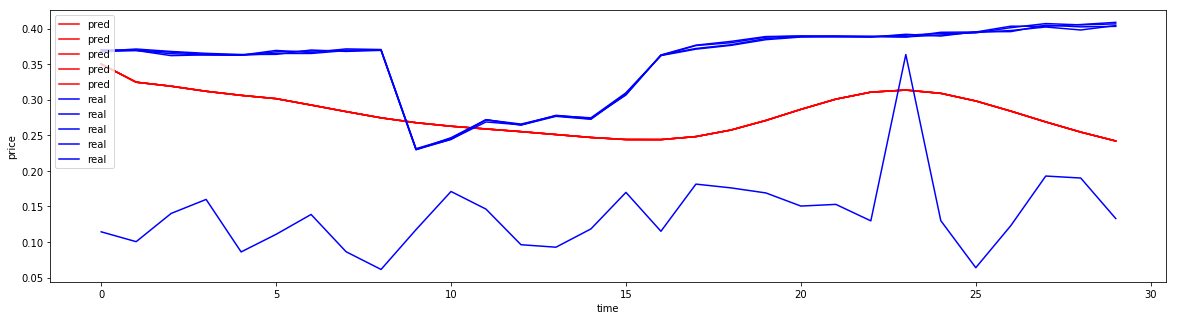

In [339]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

fig, aax = plt.subplots()

aax.plot(predict_data, 'r', label='pred') #model3.predict(dataX)
aax.plot(val_data, 'b', label='real') #dataY3


aax.set_xlabel('time')
aax.set_ylabel('price')

aax.legend(loc='upper left')

plt.show()

In [211]:
predict_data__ = np.reshape(predict_data, (testdate,1))

ValueError: cannot reshape array of size 0 into shape (120,1)

In [507]:
scaler.inverse_transform(predict_data__)

array([[-6.37732696e-02],
       [-2.70447810e-02],
       [ 4.90211299e-02],
       [ 4.81707336e-02],
       [ 5.98336760e-03],
       [ 1.65265702e-02],
       [ 5.34940011e-03],
       [ 2.57406936e-02],
       [-4.49970916e-02],
       [-1.32189465e-02],
       [ 3.43532232e-02],
       [-1.32790708e-01],
       [-6.55426254e-02],
       [-1.34463107e-01],
       [ 8.40285707e-02],
       [ 1.91231008e-01],
       [-1.06894683e-02],
       [ 3.70377948e-02],
       [ 6.44444983e-02],
       [ 6.85647915e-02],
       [-2.08830268e-02],
       [-8.92192798e-02],
       [-2.57431883e-02],
       [ 3.78010776e-02],
       [ 1.62363324e-02],
       [ 2.97347445e-02],
       [ 4.28791620e-02],
       [-4.07457505e-03],
       [-3.97796048e-03],
       [-4.77957943e-02],
       [ 3.37185812e-02],
       [-2.06786692e-01],
       [-6.43227212e-02],
       [ 2.33015341e-02],
       [ 3.78425707e-02],
       [ 2.87586551e-02],
       [ 9.63733728e-03],
       [ 1.28824602e-02],
       [ 3.5

In [508]:
scaler.inverse_transform(val_data)

array([[-3.46586957e-03],
       [-5.63934313e-03],
       [ 1.12956874e-02],
       [-1.50400875e-02],
       [ 2.25967986e-02],
       [ 7.78737772e-03],
       [-8.14351797e-04],
       [-7.93864979e-03],
       [ 3.47189084e-03],
       [ 9.29526122e-03],
       [-4.30149303e-03],
       [ 2.01988755e-02],
       [-3.45857106e-01],
       [ 1.22584463e-01],
       [ 1.45639298e-02],
       [ 1.46046014e-01],
       [ 1.38960052e-02],
       [-1.42958853e-02],
       [ 1.69046038e-02],
       [ 9.81082083e-02],
       [ 1.47789774e-01],
       [-2.19029247e-01],
       [-3.02170080e-02],
       [-4.99395337e-03],
       [ 2.33206728e-02],
       [ 1.84723976e-02],
       [ 4.75386846e-05],
       [ 1.07802462e-02],
       [-8.46859613e-04],
       [-4.73227297e-02],
       [ 1.88209794e-02],
       [-1.13479849e-02],
       [ 6.68800853e-03],
       [ 1.67900890e-02],
       [-1.29263932e-03],
       [-3.08627443e-01],
       [ 2.63352221e-01],
       [ 6.09666573e-03],
       [ 2.5

In [509]:
np.mean(predict_data__)

-0.0071256972383707765

In [510]:
np.mean(val_data)

0.015605950318183518

In [291]:
ex_data = np.reshape(test_data, (1, 1, 120))

ValueError: cannot reshape array of size 12 into shape (1,1,120)

In [219]:
value = model.predict(ex_data)
print(value)
#predict_data = []

[[0.87835485]]


In [220]:
np.append(ex_data, value)

array([0.88110165, 0.94337778, 0.89606787, 0.98386973, 0.94213059,
       0.94903169, 0.94612159, 0.93764072, 0.93847218, 0.91527453,
       0.9168543 , 0.920679  , 0.90795771, 0.9061285 , 0.92467   ,
       0.92724751, 0.91851721, 0.89631731, 0.75305727, 0.77330325,
       0.79172002, 0.84800966, 0.88143423, 0.93581152, 0.9101195 ,
       0.97472371, 0.94055082, 0.96724059, 0.9139442 , 0.9072094 ,
       0.92051271, 0.92915986, 0.93589466, 0.93165423, 0.93398231,
       0.93664298, 0.91677115, 0.94562271, 0.95410357, 0.95767884,
       0.96457993, 0.97048328, 0.72736525, 0.84942314, 0.88168367,
       0.92899357, 0.90288582, 0.96773947, 0.97979559, 0.97405854,
       0.96807205, 0.95510132, 0.96191927, 0.96025636, 0.96009006,
       0.95368784, 0.95975748, 0.95909232, 0.95684738, 0.96208556,
       0.96108781, 0.97355967, 0.73285286, 0.84834224, 0.89798023,
       0.94437553, 0.95119347, 0.9632496 , 0.98012818, 0.96665857,
       0.97646977, 0.96715745, 0.96790576, 0.97239563, 0.96649